# He Li -- 01975874

# Part1. Import Data and Library

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from time import time
import copy

# choose preferred font size and style here for plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.serif'] = 'Times'

In [2]:
# importing the datasets
xtrain = np.load("x_train.npy")
ytrain = np.load("y_train.npy")
xtest = np.load("x_test.npy")
ytest = np.load("y_test.npy")
print(xtrain.shape,xtest.shape) # show the shape of data we need to deal with

(12302, 1000) (3076, 1000)


In [3]:
device = torch.device('cpu') # choose cpu as the place we want to store data and model

Here are some examples of visualisation of plots showing features of the waveforms.

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


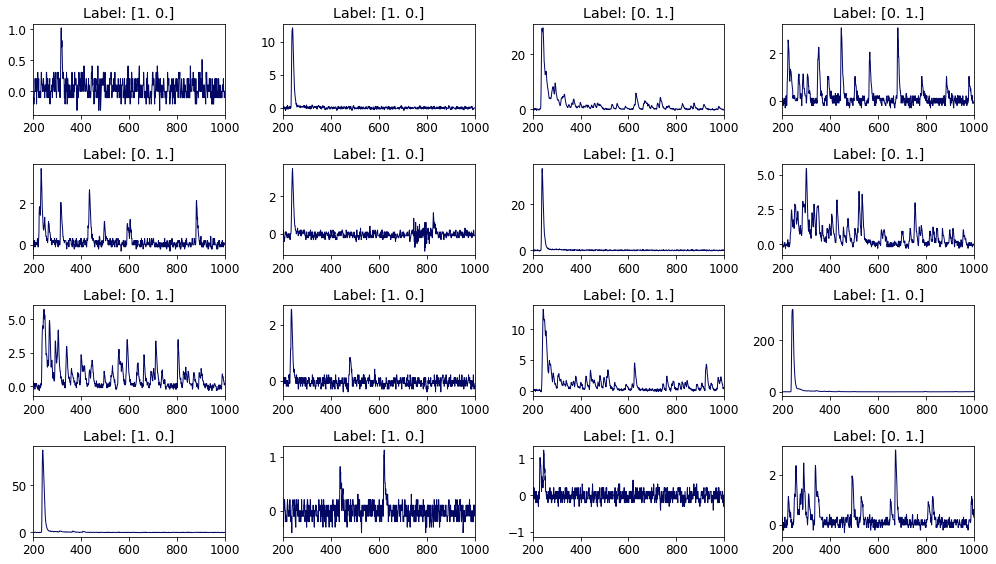

In [4]:
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.flatten()
for i in range(0, 16):
    j = np.random.randint(0, len(xtrain))
    #print(j)
    ax[i].plot(xtrain[j],color='xkcd:darkblue',lw=1)
    ax[i].set_title("Label: {}".format(ytrain[j]))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time
fig.tight_layout()

From observation of these plots, we can see that there are huge differences between ES and NS signals. ES signals usually have a fast time response of a few nanoseconds. Therefore, what can be seen in ES figures is that waveforms have very sharp peaks, and other fluctuations except peaks are within a stable range and usually very small. As for NS signals, they have a long trail of fast pulses that slowly decreases in amplitude. Therefore, compared with ES signals, figures for NS signals intend to have larger and more intensive fluctuations, so peaks are not very clear and distinct.

# Part2. Define Dataset with augmentation

We need to define a suitable dataset that combines signals and labels together. First of all, it is very necessary to define the init block which contains all parameters we need in this class, so what we have is all about input data for signals and labels. Then, defining the length of training data is sometimes useful, but not necessary here. For the augmentation part, we take the last 800 data points of the signal because each digitised waveform is a 1000 samples long with recorded pulses starting at a fixed time around 250 samples. In this way, we can make the data of signals more precise, reduce the interference of unnecessary information and make computations more efficient. Finally, we need to transform each signal into the suitbale torch size, allowing it to be used for 1D CNN model. In this part, using torch.from_numpy and unsqueeze(0) is key. Torch.from_numpy transforms numpy to tensor, while unsqueeze(0) returns a new tensor with a dimension of size one inserted at the specified position.

In [5]:
class EN_Dataset(Dataset):
    def __init__(self, train_input, train_output):
        self.train_input = train_input
        self.train_output = train_output
        
    def __len__(self):
        return len(self.train_input)
    
    def _augmentations(self,input_data):
        input_data = input_data[200:]
        return input_data
    
    def __getitem__(self, idx):
        x = self.train_input[idx]
        x = np.array(x, dtype=np.float32)
        y = self.train_output[idx]
        x = self._augmentations(x)
        out_x = torch.from_numpy(x).unsqueeze(0)
        out_y = torch.tensor(y, dtype=torch.float32)
        return out_x, out_y

After having a proper dataset, I use dataloader to wrap an iterable around the Dataset to enable easy access to the samples. I define the batch size as equal to 20, which means every time 20 samples would be propagated through the 1D CNN.

In [6]:
batch_size = 10

train = EN_Dataset(xtrain, ytrain)
test = EN_Dataset(xtest,ytest)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

For every train_loader, it stores the signals and their corresponding labels, and so dose test_loader. In the end, all signals have one channel and 800 data points after the dataset's processing, and labels have 2 dataponts. [1,0]  represents the fast ES signals, and [0,1] represents the slower signals NS.

In [7]:
signals, labels = next(iter(train_loader))
signals.shape, labels.shape

(torch.Size([10, 1, 800]), torch.Size([10, 2]))

# Part 3. Define model

We need to build a 1D CNN classifier, majorly used where the input is sequential such as signals, and the filter sildes along the single dimension to produce an output.

I apply the first convolutional layer over the input and the input size is [batch_size, input_channels, signal_length], so we need to decide the parameters for nn.Conv1d() based on the input size. The first parameter in_channels should be the same with the number of channels in the input signal, which is 1. The second parameter out_channels is the number of channels produced by the convolution, indicating how many different kinds of fentures are extracted. I set this parameter to 10 to allow the layer to potentially learn more useful features about the input data. The kernel size refers to the dimensions of the sliding window over the input and this hyperparameter has a massive impact on the classification task. For this task, I choose a relatively small kernel size, because it leads to a smaller reduction in layer dimensions and is able to extract a much larger amount of information containing highly local features from the input. I suppose a kernel size of 3 leads to a better performance for the classification task. Beides, we use padding = 1 to make the output amount of data points in each dimension be the same as the input.

After the first convolutional layer, we decide to use Maxpool layer to decrease the spatial extent of the network, which reduces the parameters and overall computation of the network. In the 1D CNN architecture below, the pooling layers use a 1 x 2 kernel and a stride of 2, which means the operation slides the 1 x 2 kernel with the stride of 2 over the input while only selecting the largest value at each kernel slice from the input to yield a value for the output. By discarding so many values, 1D CNN is more computationally efficient and avoids overfitting.

Then we use ReLU as the activation Function. This activation function is applied elementwise on every value from the input tensor. Non-linearity is necessary to produce non-linear decision boundaries, so ReLU applies much-needed non-linearity into this model. Compared with Sigmoid, ReLU has faster convergence in SGD.

Then, we construct the second convolutional layer. The channels_in parameter in the second convolutional layer should be the same with the channels_out parameter in the first convolutional layer, which is 10. Later, we decide to take 20 as the channel_out parameter for this layer to record even more features of signals. Different from the first part, we also use the dropout layer to randomly zero some of the elements of the input tensor to avoid overfitting. 

During the convolution process, the change of every signal'size is: [1, 1, 800] ---[1, 20, 800] (1. Conv1d) ---[1, 20, 400] (1. Maxpool1d) ---[1, 40, 400] (2. Conv1d) ---[1, 40, 200] (2. Maxpool1d). After using all these convolutional layers to map data into an implicit feature space, we use the flatten layer to convert a three-dimensional tensor into a one-dimensional vector to fit the input of a fully-connected layer for classification. In the first linear layer, we make a linear transformation from 4000 data points to 50 data points. In the second linear layer, 50 data points are transformed to 2 data points because this is a binary classification. We also need to use some functions like ReLU and Dropout to avoid overfitting. Finally, we use the sigmoid function to squish any real number into a range between 0 and 1, which is a very common activation function to use as the last layer of binary classifiers because it treats model predictions as probabilities that the output is true. Beides, we want to use BCEloss as the loss function in the training part, so sigmoid function is necessary here.

Finally, we use the function named Forward to make the input pass completely through the network, so this is the whole model architecture.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 20, kernel_size=3, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Conv1d(20, 40, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.MaxPool1d(2),
            nn.ReLU()
            
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(8000, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 2),
            nn.ReLU(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 8000)
        x = self.fc_layers(x)
        return x

# Part 4. Training and Testing Model

After defining a proper model, the most important thing is to train and test it. 

Training function has the input parameters, including model, device, train_loader, optimizer and epoch. model.train() tells the program that this model is in training mode. It is important when the model has dropout layers. Then, we load the data and target from the train loader. We also clear gradients for next train to do the parameter update correctly. Later, we make the data go through the model we have already defined to get outputs. As for the loss function, we use BCEloss because it creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities. Finally, we back propagate, compute gradients and apply them. For every 100 batches, we print the value of loss, the current epoch and record how many signals has been trained.

Test function has the input parameters, including model, device, test_loader and epoch. With model.eval() and torch.no_grad(), we turn off gradients computations to reduce memory usage and speed up computations. Then, we load the data and target from the test loader and make the data go through the trained model. Later, we sum up batch loss to calculate the average loss for each epoch. In the testing part, the most important thing is to make predictions to calculate the accuracy. We decide to find the index of the max probability of the output, to see if it macthes the index of the target's maximum value. If it does, then we could see this as a correct preediction. Through dividing the number of correct predictions by the amount of data in the test set, we get the value of accuracy.

In [9]:
loss_func = nn.BCELoss()
all_output = []
training_loss = []
testing_loss = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # clear gradients for next train
        output = model(data) #input data of signals and predict based on signals
        loss = loss_func(output, target)
        train_loss += loss.item()
        loss.backward() # backpropagation, compute gradients
        optimizer.step()  # apply gradients
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    training_loss.append(train_loss)
    
            

            
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item() # sum up batch loss
            
            if epoch == 1:
                all_output.append(output.tolist())
                
            pred = output.max(1)[1] # get the index of the max probability
            pred_1 = output.max(1)[0]
            pred_y.append(pred_1.tolist())
            target = target.max(1)[1]
            target_y.append(target.tolist())
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    testing_loss.append(test_loss)
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

We choose to use SGD as the optimizer to update parameters based on the computed gradients. In the optimizer, Learning rate is very important because it controls how much to change the model in response to the estimated error each time the model weights are updated. Too small value could lead to a very long training process that could get stuck, while too large value may result in an unstable process. After debugging several times, we take the learning rate as 0.005 to make the value of accuracy be in a relatively stable range.

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005)

By printing the model and the number of parameters in it, we could visually check if there is any setting error.

In [11]:
print(model)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Net(
  (conv_layers): Sequential(
    (0): Conv1d(1, 20, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(20, 40, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8000, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=2, bias=True)
    (4): ReLU()
    (5): Sigmoid()
  )
)


(402672, [60, 20, 2400, 40, 400000, 50, 100, 2])

For every epoch, we want to see its ROC curve and AUC value. 

Train Epoch: 1 [0/12302 (0%)]	Loss: 0.353760
Train Epoch: 1 [1000/12302 (8%)]	Loss: 0.405579
Train Epoch: 1 [2000/12302 (16%)]	Loss: 0.407116
Train Epoch: 1 [3000/12302 (24%)]	Loss: 0.433465
Train Epoch: 1 [4000/12302 (32%)]	Loss: 0.349426
Train Epoch: 1 [5000/12302 (41%)]	Loss: 0.369622
Train Epoch: 1 [6000/12302 (49%)]	Loss: 0.349981
Train Epoch: 1 [7000/12302 (57%)]	Loss: 0.347443
Train Epoch: 1 [8000/12302 (65%)]	Loss: 0.354000
Train Epoch: 1 [9000/12302 (73%)]	Loss: 0.368685
Train Epoch: 1 [10000/12302 (81%)]	Loss: 0.356161
Train Epoch: 1 [11000/12302 (89%)]	Loss: 0.448341
Train Epoch: 1 [12000/12302 (97%)]	Loss: 0.354291

Test set: Average loss: 0.0387, Accuracy: 3007/3076 (98%)

Train Epoch: 2 [0/12302 (0%)]	Loss: 0.349075
Train Epoch: 2 [1000/12302 (8%)]	Loss: 0.364609
Train Epoch: 2 [2000/12302 (16%)]	Loss: 0.363617
Train Epoch: 2 [3000/12302 (24%)]	Loss: 0.348977
Train Epoch: 2 [4000/12302 (32%)]	Loss: 0.353438
Train Epoch: 2 [5000/12302 (41%)]	Loss: 0.354866
Train Epoch: 2 [

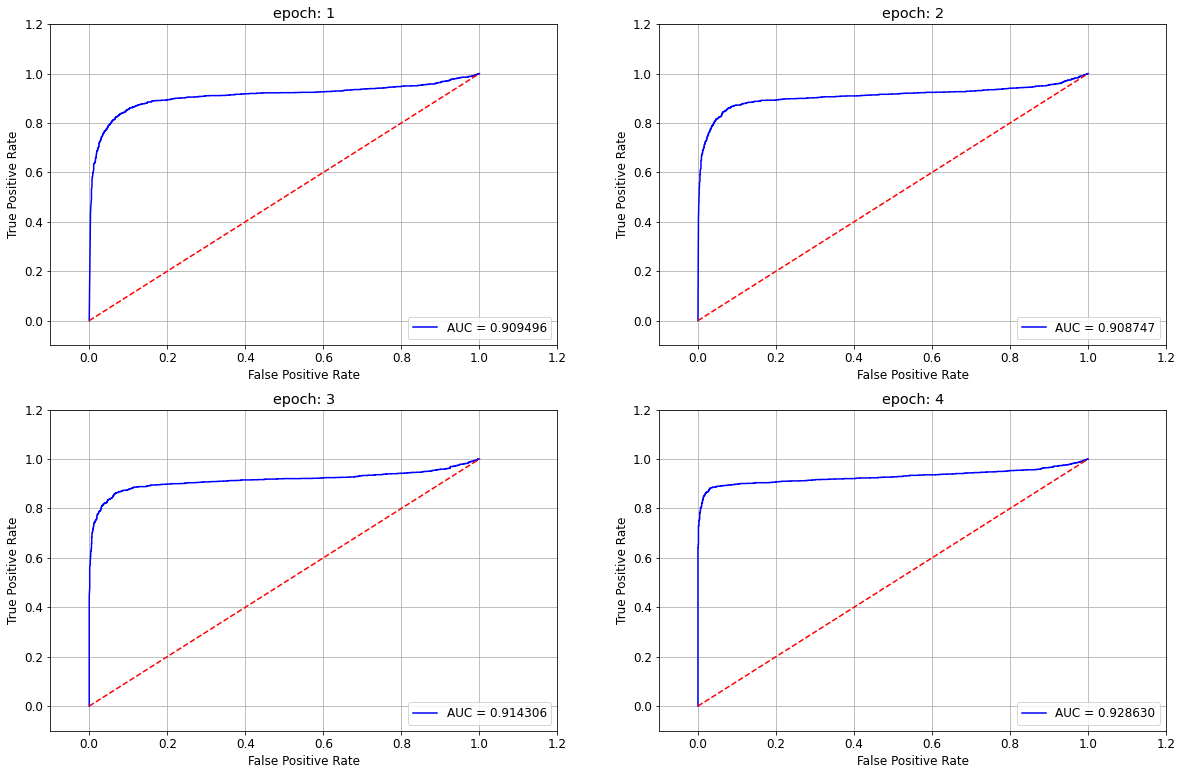

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

num_epochs = 4
fig, ax = plt.subplots(int(num_epochs/2), 2, figsize=(20, 13))
ax = ax.flatten()

for epoch in range(1, num_epochs + 1):
    pred_y = []
    target_y = []
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, epoch)
    def flatten(t): # change a list of lists to a flatten list
        return [item for sublist in t for item in sublist]
    y_true = np.array(flatten(target_y)) # change the list to an array
    y_score = np.array(flatten(pred_y))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(false_positive_rate, true_positive_rate)
        
    ax[int(epoch-1)].plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
    ax[int(epoch-1)].legend(loc='lower right')
    ax[int(epoch-1)].plot([0, 1], [0, 1], 'r--')
    ax[int(epoch-1)].set_xlim([-0.1, 1.2])
    ax[int(epoch-1)].set_ylim([-0.1, 1.2])
    ax[int(epoch-1)].set_ylabel('True Positive Rate')
    ax[int(epoch-1)].set_xlabel('False Positive Rate')
    ax[int(epoch-1)].set_title("epoch: {}".format(epoch))   
    ax[int(epoch-1)].grid()

From the output results, it can be seen that the accuracy gradually and slowly increases, which means the model has better performance with the training epoches increases. The overall level > 95% was maintained from the first epoch. This is because there is huge difference between ES and NS signals, so our network model could easily make classifications of two signals without too much training process. 

This is also reflected in the ROC curve. I plot the ROC curve for each epoch and they have similiar trends. With the number of epoches increasing, the value of AUC becomes larger, which also means this classifirer has a better performance. However, my model could not be able to achieve an AUC > 95% no matter how I change its batch size, convolutional layers, learning rate and so no.

However, the value of accuracy changes for each run. At the beginning, I thought it was because the learning rate of optimizer is too large value to have an stable process, but setting it less than 0.1 dosen't work. Then I thought maybe the number of convolutional layers have an influence on the accuracy, but when I change it to 3 layers, the accuracy even decreases.

Text(0, 0.5, 'loss')

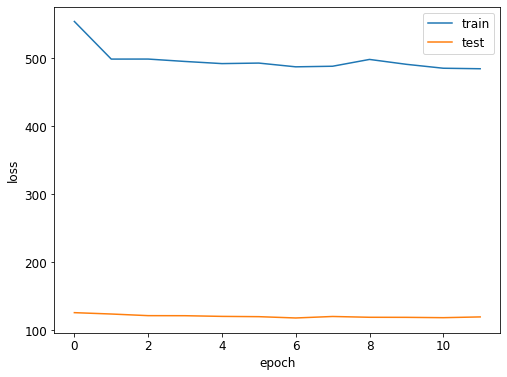

In [25]:
plt.plot(training_loss, label = 'train')
plt.plot(testing_loss, label = 'test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

The training loss and testing loss are both decresing despite some small fluctions, which is what we expected. Bsides, the testing loss is much smaller than the traing loss.

# Part 5. Output of the Model

## 1. Output label

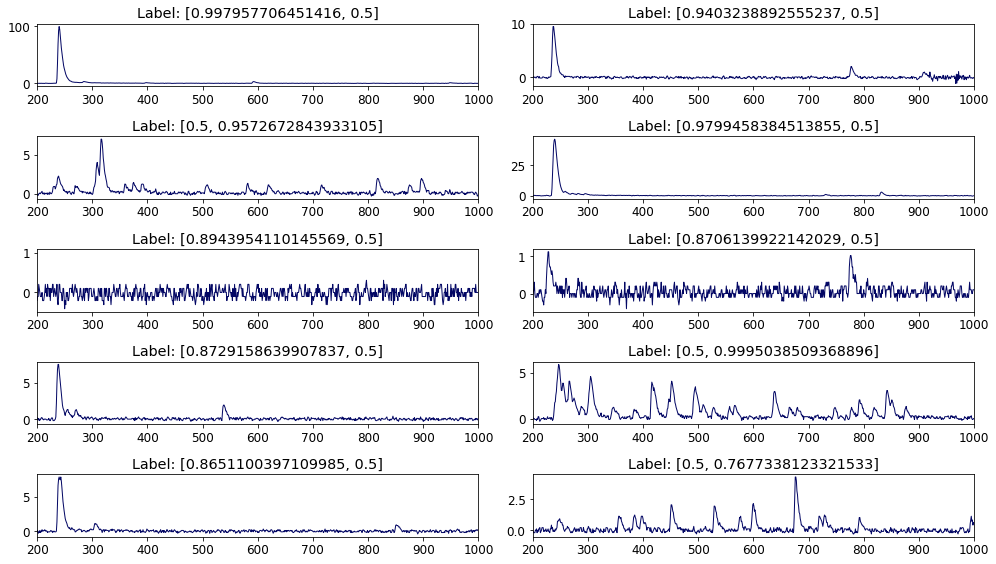

In [26]:
def flatten(t):
    return [item for sublist in t for item in sublist]

new_output = flatten(all_output)

fig, ax = plt.subplots(5,2, figsize=(14, 8))
ax = ax.flatten()
for i in range(0, 10):
    ax[i].plot(xtest[i],color='xkcd:darkblue',lw=1)
    ax[i].set_title("Label: {}".format(new_output[i]))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time
fig.tight_layout()

## 2. Original label

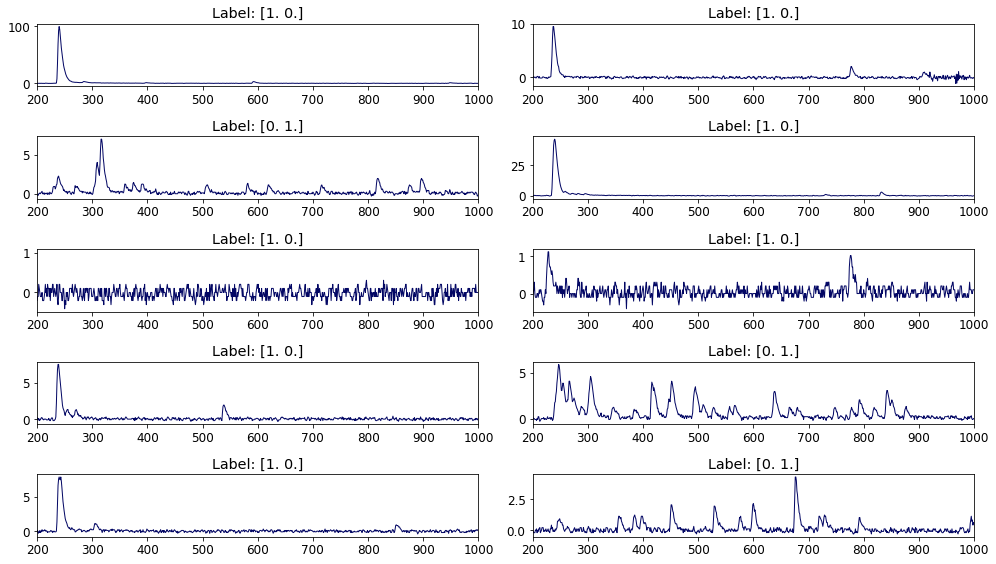

In [15]:
fig, ax = plt.subplots(5,2, figsize=(14, 8))
ax = ax.flatten()
for i in range(0, 10):
    ax[i].plot(xtest[i],color='xkcd:darkblue',lw=1)
    ax[i].set_title("Label: {}".format(ytest[i]))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time
fig.tight_layout()

By comparing these two parts, we can see that output labels tends to have larger probabilities in the position where originals labels has 1, so the value of output means the probabilities that close to 1. By doing this, the classifier could be able to distinguish between ES and NS signals.

# Part 6. Feature Map

In this part, we show what and how many layers we have in this model.

In [16]:
weights = []
conv_layers = []
maxpooling_layers = []
model_children=list(model.children())
for children in model_children:
    if type(children) == nn.Conv1d:
        #print(children)
        weights.append(children.weight)
        conv_layers.append(children)
    elif type(children) == nn.MaxPool1d:
        #print(children)
        maxpooling_layers.append(children)
    elif type(children) == nn.Sequential:
        print(type(children))
        for grandchildren in list(children.children()):
            print(type(grandchildren))
            if type(grandchildren) == nn.Conv1d:
                #print(type(grandchildren))
                weights.append(grandchildren.weight)
                conv_layers.append(grandchildren)
            if type(grandchildren) == nn.MaxPool1d:
                #print(type(grandchildren))
                maxpooling_layers.append(grandchildren)    
            
print('len(weights):', len(weights))
print('len(conv_layers):', len(conv_layers))
print('len(maxpooling_layers):', len(maxpooling_layers))

<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv1d'>
<class 'torch.nn.modules.pooling.MaxPool1d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.conv.Conv1d'>
<class 'torch.nn.modules.dropout.Dropout'>
<class 'torch.nn.modules.pooling.MaxPool1d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.dropout.Dropout'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.activation.Sigmoid'>
len(weights): 2
len(conv_layers): 2
len(maxpooling_layers): 2


Then, we pick up signal 5 to see its feature map and how our network extracts features of it.

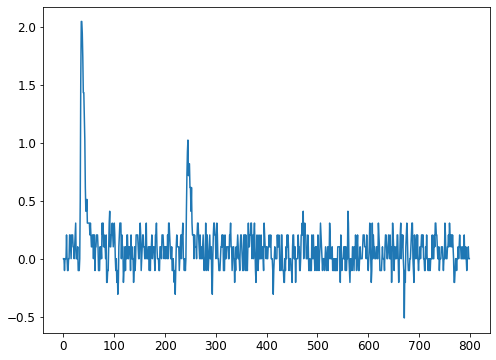

In [17]:
outputs_from_layer = []
signals_from_prev_layer = signals[5]
plt.plot(signals_from_prev_layer.squeeze())
signals_from_prev_layer = signals_from_prev_layer.unsqueeze(0)
for a in range(len(conv_layers)):
    signals_from_prev_layer = conv_layers[a](signals_from_prev_layer)
    outputs_from_layer.append(signals_from_prev_layer)
    signals_from_prev_layer = maxpooling_layers[a](signals_from_prev_layer)
    outputs_from_layer.append(signals_from_prev_layer)

1st Conv1d layer
Max, idx:  1.9519203 672
Min, idx:  -2.232816 36


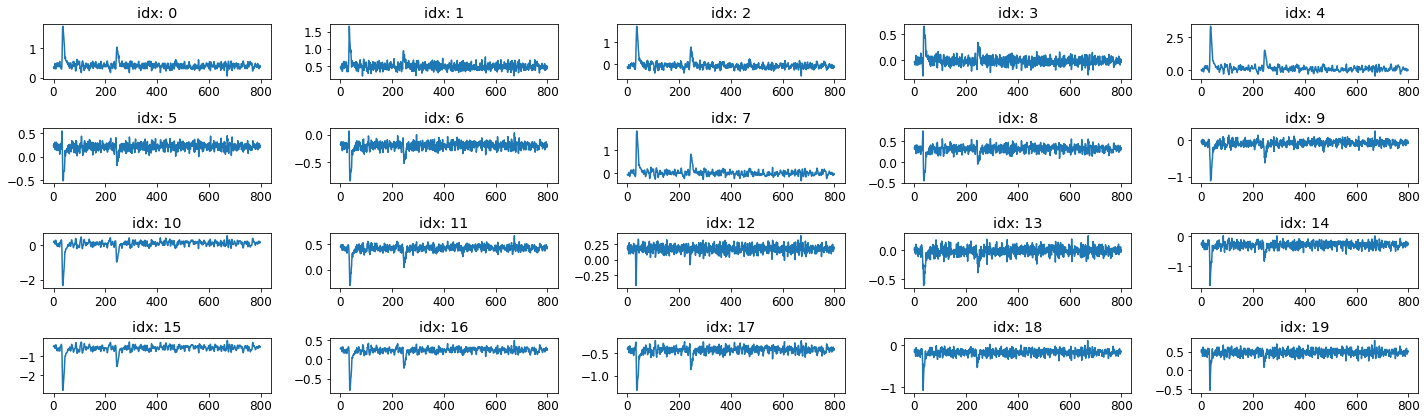

In [19]:
# Feature maps of the first Conv1d layer
# There are 20 filters

layer_number = 0
feature_maps = outputs_from_layer[layer_number].detach().numpy()

output_from_filters = feature_maps.sum(axis=1)
idx_max = output_from_filters.argmax()
max = output_from_filters.max()
idx_min = output_from_filters.argmin()
min = output_from_filters.min()

print('1st Conv1d layer')
print('Max, idx: ', max, idx_max)
print('Min, idx: ', min, idx_min)

figs, axes = plt.subplots(4, 5, figsize=[20,6])
for i in range(feature_maps.shape[1]):
    feature_map = feature_maps[0,i,:]
    axes[int(i/5), int(i%5)].set_title('idx: {0}'.format(i))
    axes[int(i/5), int(i%5)].plot(feature_map)

plt.tight_layout()

1st Conv1d layer
Max, idx:  3.622872 16
Min, idx:  -1.4244876 18


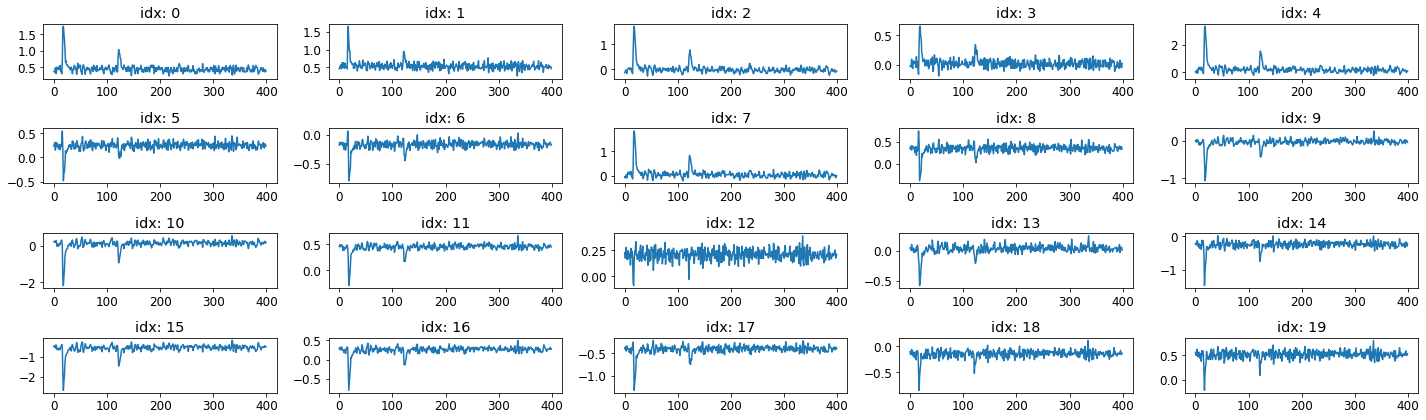

In [20]:
# Feature maps of the first Maxpooling1D layer

layer_number = 1
feature_maps = outputs_from_layer[layer_number].detach().numpy()

output_from_filters = feature_maps.sum(axis=1)
idx_max = output_from_filters.argmax()
max = output_from_filters.max()
idx_min = output_from_filters.argmin()
min = output_from_filters.min()

print('1st Conv1d layer')
print('Max, idx: ', max, idx_max)
print('Min, idx: ', min, idx_min)

figs, axes = plt.subplots(4, 5, figsize=[20,6])
for i in range(feature_maps.shape[1]):
    feature_map = feature_maps[0,i,:]
    axes[int(i/5), int(i%5)].set_title('idx: {0}'.format(i))
    axes[int(i/5), int(i%5)].plot(feature_map)

plt.tight_layout()

2nd Conv1d layer
Max, idx:  14.840389 18
Min, idx:  -2.369712 109


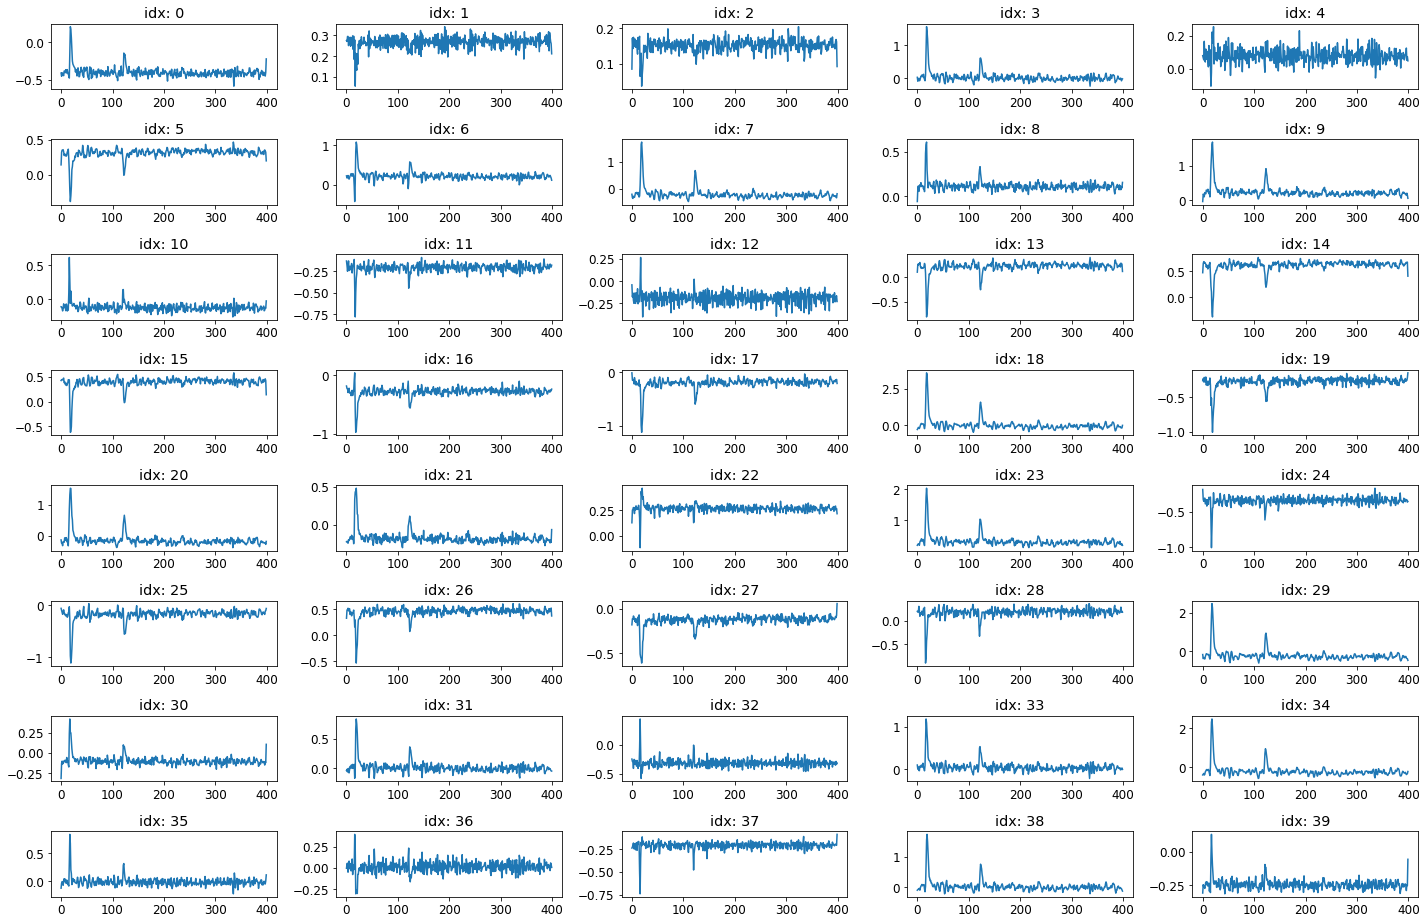

In [21]:
# Feature maps of the second Conv1d layer
# There are 40 filters

layer_number = 2
feature_maps = outputs_from_layer[layer_number].detach().numpy()

output_from_filters = feature_maps.sum(axis=1)
idx_max = output_from_filters.argmax()
max = output_from_filters.max()
idx_min = output_from_filters.argmin()
min = output_from_filters.min()

print('2nd Conv1d layer')
print('Max, idx: ', max, idx_max)
print('Min, idx: ', min, idx_min)

figs, axes = plt.subplots(8, 5, figsize=[20,13])
for i in range(feature_maps.shape[1]):
    feature_map = feature_maps[0,i,:,]
    axes[int(i/5), int(i%5)].set_title('idx: {0}'.format(i))
    axes[int(i/5), int(i%5)].plot(feature_map)

plt.tight_layout()

2nd Conv1d layer
Max, idx:  16.900126 8
Min, idx:  -1.3645233 54


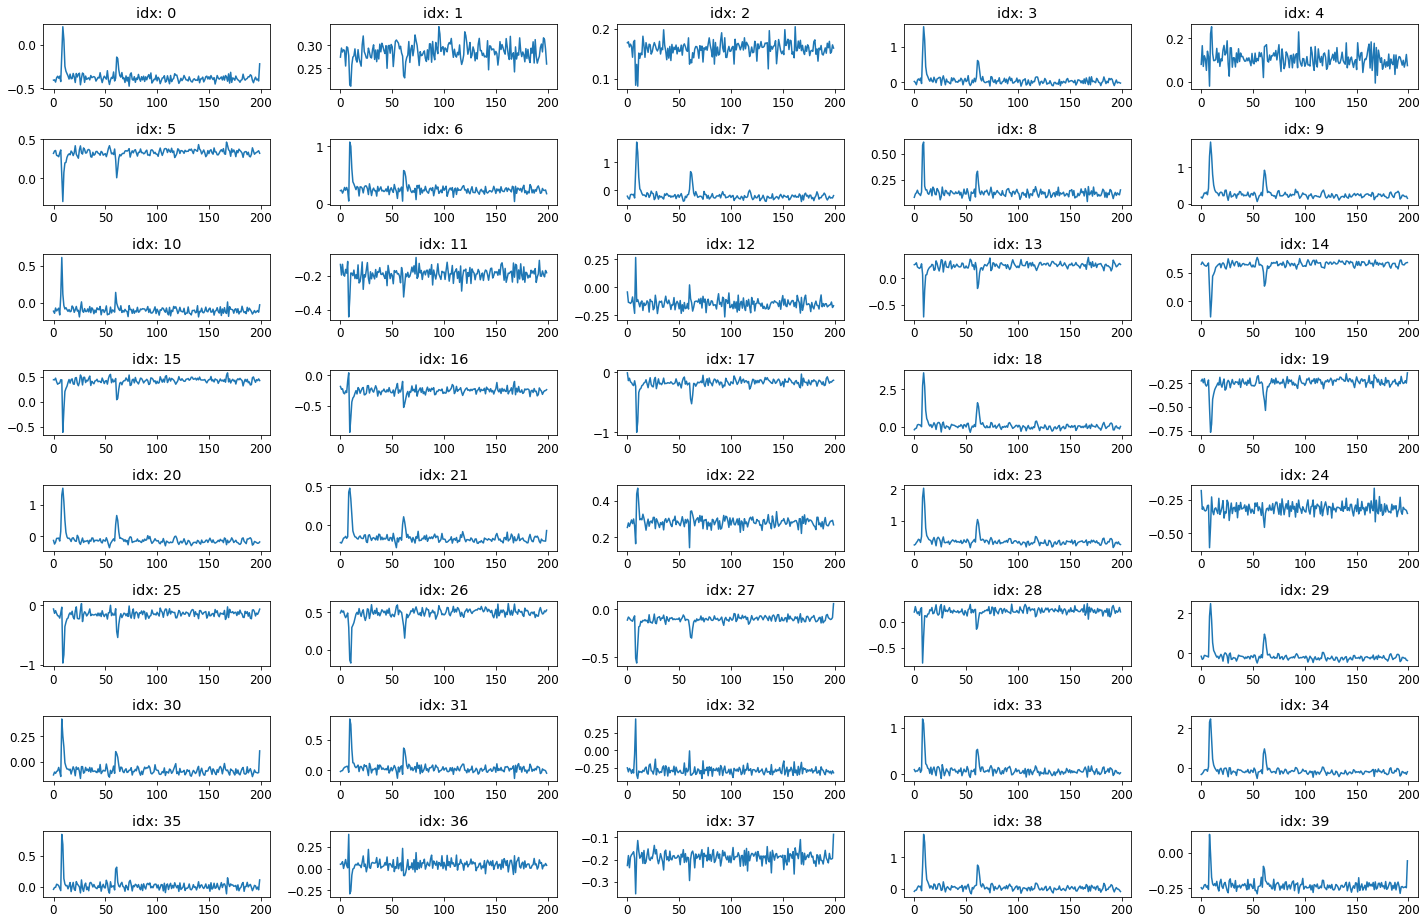

In [22]:
# Feature maps of the second Maxpooling layer
# There are 40 filters

layer_number = 3
feature_maps = outputs_from_layer[layer_number].detach().numpy()

output_from_filters = feature_maps.sum(axis=1)
idx_max = output_from_filters.argmax()
max = output_from_filters.max()
idx_min = output_from_filters.argmin()
min = output_from_filters.min()

print('2nd Conv1d layer')
print('Max, idx: ', max, idx_max)
print('Min, idx: ', min, idx_min)

figs, axes = plt.subplots(8, 5, figsize=[20,13])
for i in range(feature_maps.shape[1]):
    feature_map = feature_maps[0,i,:,]
    axes[int(i/5), int(i%5)].set_title('idx: {0}'.format(i))
    axes[int(i/5), int(i%5)].plot(feature_map)

plt.tight_layout()

By observaing there four feature maps , we can find that some unimportant information is being erased during this four layers. Compared the last feature map with the beginning one, this signal has less noise and its peak bomes more distinct, wchich means the shape of peak is what our classifier used to do classifications.

# Part 7. Conclusion

In this whole project, the goal is to do binary classifications using 1D CNN. The first step is to construct dataloader and datasets for our sginals and labels. After having them, we define the model we expect, then train and  test it. During this process, we plot ROC curve and get the AUC to see how well it performs. Finally, we obtain and vasualize output labels and features maps to have a look at what we got.

The key part is to make a proper model whose performance is good. In order to achieve this, we need to adjust all these hyperparameters to make the AUC > 95%. However, my model dose not achieve it, even though I tried to change batch size, convolutionals layers, activation functions and learning rate several times. The highest AUC is still 92.8%. It seems like these hyperparameters donot have an affect on AUC. I suppoose this is because ES and NS signals are very easy to classify, so no matter what parameters we have, the model have similar performance.

In sum, the output of the model is quite good and is what we expect. Feature maps are also clear to see how signals are changing during passing through this network. However, I still do not very understand how to make my model provide the AUC>95%.